# Decoupling fusion & differentiation

## Installations & Downloads

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle
import scipy
import pandas as pd
from scipy import stats
from scipy.stats import normaltest

sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))

import TimeSeriesAnalysis.consts as consts
import TimeSeriesAnalysis.params as params
from TimeSeriesAnalysis.auc_over_time_diff_prob import *
from TimeSeriesAnalysis.single_cell_properties_calc import get_displacement

from TimeSeriesAnalysis.utils.data_load_save import *
from TimeSeriesAnalysis.utils.plots_functions_utils import *

import warnings
warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

ModuleNotFoundError: No module named 'TimeSeriesAnalysis'

# Load the data

In [2]:
def convert_score_df(score_df, modality):
    """converts the scores dataframe from horizontal to vertical view"""
    df = pd.DataFrame()
    for i in range(len(score_df)):
        track = score_df.iloc[i, :]
        tmp_df = pd.DataFrame({f"score_{modality}":track.drop(index="Spot track ID")})
        tmp_df["time"] = tmp_df.index * 5 / 60
        tmp_df["Spot frame"] = tmp_df.index
        tmp_df["Spot track ID"] = track["Spot track ID"]
        df = df.append(tmp_df, ignore_index=True)
    return df

In [3]:
# load fuaion data:  

def load_fusion_data(path=consts.storage_path + r"data/mastodon/no_reg_S3 all detections.csv"):
   # load the raw data with fusion tags
    chunksize = 200000
    df = pd.DataFrame()
    for chunk in pd.read_csv(path, chunksize=chunksize, encoding="cp1252", header=[0, 1], iterator=True):
        chunk.columns = ['_'.join(col) for col in chunk.columns]
        chunk = chunk[chunk["manual_manual"] == 1]
        df = df.append(chunk, ignore_index=True)

    df.rename(columns=lambda x: x.replace("_", " ").strip(), inplace=True)
    fusion_cols = ['Spot track ID', 'Spot frame', 'Spot position X', 'Spot position Y', 'manual manual'] + [col for col in df.columns if "First" in col]
    df = df[fusion_cols]
    df.rename(columns=lambda x: x.split(" ")[3] if "First" in x else x, inplace=True)
    df = df[1:]
    df = df.astype(float)

    c = df.iloc[:,5:].idxmax(axis=1)
    is_valid = df.iloc[:,5:].sum(axis=1) > 0
    c[~is_valid] = np.nan
    df["fusion_frame"] = c
    df = df.dropna(subset=["fusion_frame"])
    df = df.drop_duplicates(subset=['fusion_frame', 'Spot track ID'])
    fusion_time_df = df[['Spot track ID' ,'fusion_frame']] #,'manual manual'
    fusion_time_df["fusion_time"] = fusion_time_df["fusion_frame"].astype(float) * 5 / 60
    return fusion_time_df

fusion_time_df = load_fusion_data(path=consts.storage_path + r"data/mastodon/no_reg_S3 all detections.csv")
tagged_tracks_s3, _ = get_tracks(consts.data_csv_path % (params.registration_method, "S3"), tagged_only=True)

fusion_scores = fusion_time_df.merge(tagged_tracks_s3.drop(columns="manual"), on=["Spot track ID"], how="left")
del fusion_time_df
del tagged_tracks_s3

scores_df_s3_mot = pickle.load(open(consts.motility_model_path % (1, 5) + "df_score_vid_num_S3.pkl", 'rb'))
scores_df_s3_int = pickle.load(open(consts.intensity_model_path % (1, 5) + "df_score_vid_num_S3.pkl", 'rb'))

scores_df_s3_mot = convert_score_df(scores_df_s3_mot, "motility")
scores_df_s3_int = convert_score_df(scores_df_s3_int, "intensity")


fusion_scores = fusion_scores.merge(scores_df_s3_mot, on=["Spot track ID", "Spot frame"], how="left")
fusion_scores = fusion_scores.merge(scores_df_s3_int[["Spot track ID", "Spot frame", "score_intensity"]], on=["Spot track ID", "Spot frame"], how="left")
del scores_df_s3_mot
del scores_df_s3_int

fusion_scores = fusion_scores.drop_duplicates(subset=["Spot track ID", "Spot frame"])

fusion_scores.head(3)

Spot track ID fusion_frame  fusion_time  Spot position X  Spot position Y  \
0          217.0          179    14.916667       725.925171       585.328003   
2          217.0          179    14.916667       729.656006       584.194153   
4          217.0          179    14.916667       734.618469       583.389587   

  Spot frame score_motility      time score_intensity  
0          0            NaN  0.000000             NaN  
2          1            NaN  0.083333             NaN  
4          2            NaN  0.166667             NaN

In [4]:
s = ""
for id in fusion_scores["Spot track ID"].unique():
    s+= f"vertexFeature('Spot track ID') =={id} | "
s

"vertexFeature('Spot track ID') ==217.0 | vertexFeature('Spot track ID') ==9406.0 | vertexFeature('Spot track ID') ==18989.0 | vertexFeature('Spot track ID') ==16771.0 | vertexFeature('Spot track ID') ==12526.0 | vertexFeature('Spot track ID') ==11178.0 | vertexFeature('Spot track ID') ==9241.0 | vertexFeature('Spot track ID') ==1394.0 | vertexFeature('Spot track ID') ==27217.0 | vertexFeature('Spot track ID') ==16991.0 | vertexFeature('Spot track ID') ==16003.0 | vertexFeature('Spot track ID') ==14919.0 | vertexFeature('Spot track ID') ==3656.0 | vertexFeature('Spot track ID') ==16042.0 | vertexFeature('Spot track ID') ==6208.0 | vertexFeature('Spot track ID') ==14831.0 | vertexFeature('Spot track ID') ==19228.0 | vertexFeature('Spot track ID') ==10528.0 | vertexFeature('Spot track ID') ==8076.0 | vertexFeature('Spot track ID') ==23847.0 | vertexFeature('Spot track ID') ==16348.0 | vertexFeature('Spot track ID') ==23080.0 | vertexFeature('Spot track ID') ==10879.0 | vertexFeature('Spo

In [5]:
no_data_tracks = []
untracked_cells_ids = []
for track_id in fusion_scores["Spot track ID"].unique():
    track_data = fusion_scores[(fusion_scores["Spot track ID"]==track_id)]
    if len(track_data)<=1:
        if track_data["manual manual"].sum()==0:
            untracked_cells_ids.append(track_id)
        else:
            no_data_tracks.append(track_id)
        
print("number of fusion annotated cells: ", fusion_scores["Spot track ID"].nunique())
print(f"number of untracked cells: {len(untracked_cells_ids)}/{fusion_scores['Spot track ID'].nunique()}")
print(f"number of no data cells: {len(no_data_tracks)}/{fusion_scores['Spot track ID'].nunique()}")
print(f"no data cells: {no_data_tracks}")

number of fusion annotated cells:  71
number of untracked cells: 0/71
number of no data cells: 0/71
no data cells: []


# Inspect each annotated cell

In [6]:
diff_score_1st_fusion = fusion_scores[(fusion_scores["time"]==fusion_scores["fusion_time"])]
print(f"average differentiation score on first fusion (motility): {round(diff_score_1st_fusion['score_motility'].mean(),3)} +- {round(diff_score_1st_fusion['score_motility'].std(),3)}")
print(f"average differentiation score on first fusion (intensity): {round(diff_score_1st_fusion['score_intensity'].mean(),3)} +- {round(diff_score_1st_fusion['score_intensity'].std(),3)}")

average differentiation score on first fusion (motility): 0.537 +- 0.258
average differentiation score on first fusion (intensity): 0.728 +- 0.221


In [7]:
fusion_scores = fusion_scores.astype("float")

## single cell examination

In [ ]:
import matplotlib as mpl

def get_corr_values(data, time, x_prop, y_prop, rolling_w, corr_metric):
    data = data[(data["time"]>=time[0]) & (data["time"]<=time[1])]
    data = data.astype('float64')
    corr = np.array(data.groupby('Spot track ID').apply(lambda df: df[x_prop].rolling(rolling_w).mean().corr(df[y_prop].rolling(rolling_w).mean(),method=corr_metric)))
    return corr


def plot_diff_trajectories_single_cells(conf_data, modality, path=None, rolling_w=1):

    def plot(df, color1, color2, label, modality):
        for track_id, track in df.groupby("Spot track ID"):
            track = track[(track["Spot frame"]<=track["fusion_frame"])].sort_values("time")
            track[f"score_{modality}"] = track[f"score_{modality}"].rolling(rolling_w).mean()
            try:
                monotonicity = get_corr_values(track, (6,13), f"score_{modality}", "time", rolling_w=6, corr_metric="spearman")[0]
                fig = plt.figure(figsize=(8, 5))
                cmap = mpl.cm.get_cmap('RdYlGn_r')
                norm = mpl.colors.Normalize(vmin=-1, vmax=1)
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                plt.plot(track["time"], track[f"score_{modality}"], linewidth=1, color=cmap(monotonicity), label=track_id)

                plt.legend()
                plt.grid()
                plt.ylabel((0, 1))
                plt.xlabel("time (h)")
                plt.ylabel("avg score")
                plt.title(f"avg differentiation score over time ({modality})")
                plt.plot([i * 5 / 60 for i in range(260)], [0.5 for i in range(260)], color="black", linestyle="--", linewidth=2)
                if path:
                    if path:
                        plt.savefig(path + "/" + f'{np.round(monotonicity, 4)} monotonicity diff_over_t ({modality}) id={track_id}.eps', format="eps")
                plt.ylim((0,1))
                plt.xlim((4,22))
                plt.colorbar(sm, ticks=np.linspace(-1, 1, 5))
#                 plt.show()
                plt.clf()
            except: 
                continue

    for (df, label, avg_color, std_color) in conf_data:
        df = df.astype("float")
        plot(df, avg_color, std_color, label, modality)
        
    
# track_ids = [217, 18989,  16771, 9241, 1394, 16991, 16003, 19228, 23080, 16091, 4657, 27879, 5490, 8662, 8598, 14320]
# track_ids = [4657, 16003, 27879, 8598, 5490, ] #1394
# track_ids_random = np.random.choice(fusion_scores["Spot track ID"].unique(), 4, replace=False)
# track_ids_random = np.random.choice(track_ids, 30, replace=False)
track_ids_random = fusion_scores["Spot track ID"].unique()
path = consts.storage_path + "/eps_figs/monotonicity_ordered_trajectories/"
plot_diff_trajectories_single_cells([(fusion_scores[fusion_scores["Spot track ID"].isin(track_ids_random)], "ERK", "DarkOrange","Orange")], "motility", path + "motility" , rolling_w=1)
plot_diff_trajectories_single_cells([(fusion_scores[fusion_scores["Spot track ID"].isin(track_ids_random)], "ERK", "DarkOrange","Orange")], "intensity", path + "intensity", rolling_w=1)

In [33]:
def plot_all_cells(conf_data, modality, path=None, rolling_w=1):
    fig = plt.figure(figsize=(8, 5))
    cmap = mpl.cm.get_cmap('rainbow') #RdYlGn_r
    norm = mpl.colors.Normalize(vmin=-0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(-1, 1, 5))
    
    def plot(df, color1, color2, label, modality):
        for track_id, track in df.groupby("Spot track ID"):
            track = track[(track["Spot frame"]<=track["fusion_frame"])].sort_values("time")
            track[f"score_{modality}"] = track[f"score_{modality}"].rolling(rolling_w).mean()
            try:
                monotonicity = get_corr_values(track, (6,13), f"score_{modality}", "time", rolling_w=6, corr_metric="spearman")[0]
                plt.plot(track["time"], track[f"score_{modality}"], linewidth=1, color=cmap(monotonicity), label=track_id)
                
            except: 
                continue

    for (df, label, avg_color, std_color) in conf_data:
        df = df.astype("float")
        plot(df, avg_color, std_color, label, modality)
        plt.legend()
        plt.grid()
        plt.ylabel((0, 1))
        plt.xlabel("time (h)")
        plt.ylabel("avg score")
        plt.title(f"avg differentiation score over time ({modality})")
        plt.plot([i * 5 / 60 for i in range(260)], [0.5 for i in range(260)], color="black", linestyle="--", linewidth=2)
#         if path:
#             if path:
#                         plt.savefig(path + "/" + f'examplary_tracks_{modality}.eps', format="eps")
        plt.ylim((0,1))
#         plt.xlim((4,22))
        plt.show()
        plt.clf()

# ids_15_12_mot = [13962, 7339, 12526, 10528, 4657, 3637, 8598, 27879, 28929]
# ids_05_12_mot = [27879, 3637, 10528, 9241, 16771, 16003, 4657, 28929]
# ids_05_12_int = [8598, 12195, 21523, 28843, 12600, 20857, 16091, 7466, 27879, 18989, 3656, 6993, 13781,5490 ]

ids_15_01_int = [28843, 16991, 7339, 12487, 18989, 20857, 13388, 16771, 13781, 9241, 12600, 10879, 14320, 12195, 16003, 27879]
ids_15_01_mot = [13781, 28929, 27879, 4657, 3637, 21523, 10528, 13962, 8598, 12526, 5490, 16771, 11105]

ids_18_01_int = [4657, 28057, 16771, 4959, 3656,3637, 27879, 924, 28843, 9406, 12600, 8598, 17022, 7339, 7127]
ids_18_01_mot = [28929, 4657, 8598, 3637, 16771, 7339, 16003, 9241, 10528, 27879]

import itertools
for ids in list(itertools.combinations([ids_18_01_int], 3)):
    print(ids)
    plot_all_cells([(fusion_scores[fusion_scores["Spot track ID"].isin(ids)], "ERK", "DarkOrange","Orange")], "motility", consts.storage_path + "/eps_figs/" , rolling_w=1)

## summary

In [14]:
from itertools import groupby

def get_terminal_differentiation_time(diff_threshold, track_df, modality):
    track_df = track_df[(track_df["time"]<=track_df["fusion_time"])]
#     track_df = track_df.sort_values("Spot frame", ascending=False)
    high_then_thresh = track_df[(track_df[f"score_{modality}"] >= diff_threshold) & (track_df[f"time"] >= 0)]
    high_then_thresh["Spot frame diff"] = high_then_thresh["Spot frame"].diff()
    sequences = [ v for k, v in high_then_thresh.groupby((high_then_thresh["Spot frame diff"].shift() != high_then_thresh["Spot frame diff"]).cumsum())]
    if len(sequences) == 0:
        return np.nan, np.nan
    else: 
        longest_sequence = max(sequences, key=len)
        diff_frame = np.floor(longest_sequence["Spot frame"].min()) # change to adjust
#         ind  = np.array(longest_sequence[f"score_{modality}"]).argmin() #change to adjust
#         diff_frame = longest_sequence.iloc[ind]["Spot frame"]
        
        diff_time = diff_frame*1/12
        return diff_frame, diff_time


track_id = 217
track_data = fusion_scores[fusion_scores["Spot track ID"]==track_id]

_, mot_diff_time = get_terminal_differentiation_time(0.78, track_data, "motility")
_, int_diff_time = get_terminal_differentiation_time(0.78, track_data, "intensity")
# print("fusion time: ",df_fusion_props_int[df_fusion_props_int["Spot track ID"] == track_id]["fusion_time"])

# plot_single_cell_fusion_time(track_id, mot_diff_time, int_diff_time)

## calculate some fusion parameters

such as: 
* time/distance between track's start and fusion time
* time/distance between track's terminal-differentiation time (according to the threshold) and fusion time.

In [13]:
from TimeSeriesAnalysis.single_cell_properties_calc import *

def get_avg_persistence(track_df, time):
#     track_df = track_df[(track_df["time"]>=time[0]) & (track_df["time"]<=time[1])]
    x_vec = track_df["Spot position X"]
    y_vec = track_df["Spot position Y"]
    displacement = get_displacement(x_vec, y_vec)
    path_len = get_path_len(x_vec, y_vec)
    persistence = displacement / path_len
    return persistence
    
persistence_before_fusion = get_avg_persistence(fusion_scores[fusion_scores["Spot track ID"]==217.0], time=(13, 16))
persistence_before_fusion

0.05675984

In [15]:
def get_distance_to_fusion(track_df, diff_frame=None):
    """
    computes the displacement of single cell until fusion time. 
    if diff_frame=None, computes the displacement from the first time-point of the track
    else, computes the displacement from the time-point wehre the cell reached to terminal differentiation state.
    """
    start_frame = 0 if diff_frame is None else diff_frame
    track_df_cropped = track_df[track_df["Spot frame"] >= start_frame]
    if track_df_cropped.empty:
        print(track_df, start_frame)

    track_df_cropped = track_df_cropped.sort_values("Spot frame")
    displacement = get_displacement(track_df_cropped["Spot position X"], track_df_cropped["Spot position Y"])
    return displacement

def get_monotonicity(track_df, modality, time, rolling_window=6, corr_metric="spearman"):
    track_df = track_df[(track_df["time"]>=time[0]) & (track_df["time"]<=time[1])]
    corr = np.array(track_df.astype('float64').groupby('Spot track ID').apply(lambda df: df[f"score_{modality}"].rolling(rolling_window).mean().corr(df["time"].rolling(rolling_window).mean(),method=corr_metric)))
    corr = corr[0] if len(corr) > 0 else np.nan 
    return round(corr, 4)

def get_kendalltau(track_df, modality, time, rolling_window=6, corr_metric="kendalltau"):
    track_df = track_df[(track_df["time"]>=time[0]) & (track_df["time"]<=time[1])]
    x =  track_df[f"score_{modality}"].rolling(rolling_window).mean()
    y =  track_df["time"].rolling(rolling_window).mean()
    corr = stats.kendalltau(x, y, nan_policy='omit')
    corr = corr[0] if len(corr) > 0 else np.nan 
    return round(corr, 4)

def rolling_corr_mean_value(track_df, modality, time, rolling_window=30, corr_metric="spearman"):
    track_df = track_df[(track_df["time"]>=time[0]) & (track_df["time"]<=time[1])]
    corr = track_df[f"score_{modality}"].rolling(rolling_window).corr(track_df['time'], method='spearman')
    return corr.mean()

track = fusion_scores[fusion_scores["Spot track ID"]==217]
print(get_monotonicity(track, "motility", time=(6, 13)))
print(get_monotonicity(track, "motility", time=(6, 13), corr_metric="pearson"))

print(get_kendalltau(track, "motility", time=(6, 13)))

print(rolling_corr_mean_value(track, "motility", time=(6, 13), corr_metric="spearman"))
print(rolling_corr_mean_value(track, "motility", time=(6, 13), corr_metric="kendalltau"))


0.8726
0.8717
0.7089
0.6486759555204493
0.6486759555204493


In [20]:
import math
def calc_single_cell_fusion_properties(track_df, modality):
    diff_frame, diff_time = get_terminal_differentiation_time(DIFF_SCORE_THRESHOLD, track_df, modality)
    if np.isnan(diff_frame):
        return
    dist_to_fusion_start = get_distance_to_fusion(track_df, diff_frame=None)
    dist_to_fusion_diff = get_distance_to_fusion(track_df, diff_frame=diff_frame)
    n_frames_diff_fusion = abs(track_df["fusion_frame"].iloc[0] - diff_frame)
    time_diff_fusion = n_frames_diff_fusion * 5 / 60
    corr_with_time = get_monotonicity(track_df, modality, time=(2, diff_time))
    
    kendalltau_corr_with_time = get_kendalltau(track_df, modality, time=(6, diff_time))
    fusion_time = track_df["fusion_time"].iloc[0]
    persistence_before_fusion = get_avg_persistence(track_df, time=(diff_time, fusion_time))
    rolling_mean_kendalltau = rolling_corr_mean_value(track, modality, time=(6, diff_time), corr_metric="kendalltau")
    rolling_mean_spearman = rolling_corr_mean_value(track, modality, time=(6, diff_time), corr_metric="spearman")
    
    properties = {"Spot track ID": track_df["Spot track ID"].iloc[0], 
                  "fusion_time": fusion_time,
                  "diff_time": diff_time, 
                  "dist_from_start_to_fusion": dist_to_fusion_start, 
                  "dist_from_diff_to_fusion": dist_to_fusion_diff, 
                  "time_from_diff_to_fusion": time_diff_fusion,
                 "monotonicity": corr_with_time,
                  "kendalltau": kendalltau_corr_with_time,
                  "rolling_mean_kendalltau": rolling_mean_kendalltau, 
                  "rolling_mean_spearman": rolling_mean_spearman, 
                 "persistence_before_fusion": persistence_before_fusion,
                 }
    return properties

def calc_fusion_properties(df, modality):
    df_fusion_props = pd.DataFrame()
    for track_id, track_df in df.groupby("Spot track ID"):
        if len(track_df) > 1:
            fusion_properties = calc_single_cell_fusion_properties(track_df, modality)
            if fusion_properties:
                df_fusion_props = df_fusion_props.append(fusion_properties, ignore_index=True)
    return df_fusion_props


motility diff time normality NormaltestResult(statistic=2.0216487802356937, pvalue=0.3639188447751105)
motility diff time normality NormaltestResult(statistic=0.88379779955298, pvalue=0.6428146208723015)
fusion time normality NormaltestResult(statistic=4.52262804939619, pvalue=0.10421345569004366)
motility #cells dirrerentiated untill 14.5 40/56
actin #cells dirrerentiated untill 14.5 34/52
median motility 11.125
median intensity 12.708333333333334
median fusion 15.291666666666668


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


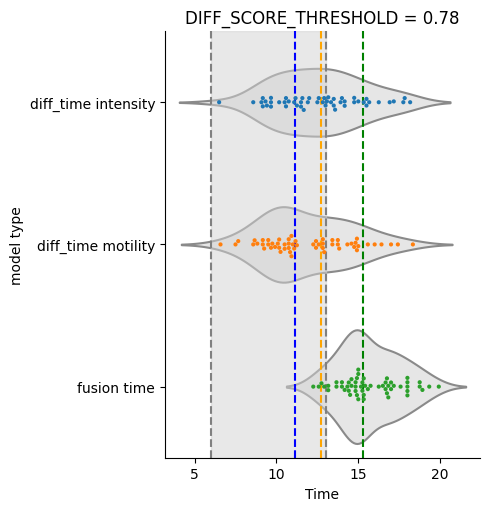

In [22]:
fusion_scores = fusion_scores.astype(float)

DIFF_SCORE_THRESHOLD = 0.78
df_fusion_props_mot_i = calc_fusion_properties(fusion_scores, "motility")  
df_fusion_props_int_i = calc_fusion_properties(fusion_scores, "intensity") 

print("motility diff time normality",normaltest(df_fusion_props_mot_i["diff_time"], nan_policy='omit'))
print("motility diff time normality",normaltest(df_fusion_props_int_i["diff_time"], nan_policy='omit'))
print("fusion time normality",normaltest(df_fusion_props_int_i["fusion_time"], nan_policy='omit'))

print("motility #cells dirrerentiated untill 14.5", f"{df_fusion_props_mot_i[df_fusion_props_mot_i['diff_time'] <= 13.5]['Spot track ID'].nunique()}/{df_fusion_props_mot_i['Spot track ID'].nunique()}")
print("actin #cells dirrerentiated untill 14.5", f"{df_fusion_props_int_i[df_fusion_props_int_i['diff_time'] <= 13.5]['Spot track ID'].nunique()}/{df_fusion_props_int_i['Spot track ID'].nunique()}")

df_fusion_props_mot_i["model type"] = "diff_time" + " motility"
df_fusion_props_int_i["model type"] = "diff_time" + " intensity"
df_fusion_props_mot_i_copy = df_fusion_props_mot_i.copy()
df_fusion_props_mot_i_copy["diff_time"] = df_fusion_props_mot_i_copy["fusion_time"]
df_fusion_props_mot_i_copy["model type"] = "fusion time"

df = pd.concat([df_fusion_props_int_i, df_fusion_props_mot_i, df_fusion_props_mot_i_copy], ignore_index=True, axis=0)
df['model type'] = df['model type'].astype('category')

sns.catplot(data=df, x="diff_time", y="model type", kind="violin", color=".9", inner=None)
sns.swarmplot(data=df, x="diff_time", y="model type", size=3)
plt.axvspan(6, 13, alpha = 0.5, color='lightgray')
plt.axvline(6, color='gray', linestyle='dashed')
plt.axvline(13, color='gray', linestyle='dashed')

plt.axvline(df_fusion_props_mot_i["diff_time"].median(), color='blue', linestyle='dashed')
plt.axvline(df_fusion_props_int_i["diff_time"].median(), color='orange', linestyle='dashed')
plt.axvline(df_fusion_props_int_i["fusion_time"].median(), color='green', linestyle='dashed')

print("median motility", df_fusion_props_mot_i["diff_time"].median())
print("median intensity", df_fusion_props_int_i["diff_time"].median())
print("median fusion", df_fusion_props_int_i["fusion_time"].median())

plt.title(f"DIFF_SCORE_THRESHOLD = {DIFF_SCORE_THRESHOLD}")
plt.xlabel("Time")
plt.savefig(consts.storage_path + f"eps_figs/diff_time_fusion_time_density_thresh={DIFF_SCORE_THRESHOLD}.eps", format="eps")
plt.show()


## correlate parameters

mean & median - motility mean 3.7574404761904767 median 3.0833333333333335
mean & median - intensity mean 3.110576923076923 median 2.958333333333333
motility diff time normality NormaltestResult(statistic=4.0595143791485535, pvalue=0.13136741465417687)
actin diff time normality NormaltestResult(statistic=4.022751859706156, pvalue=0.13380444242574083)
# cells motility 56/71


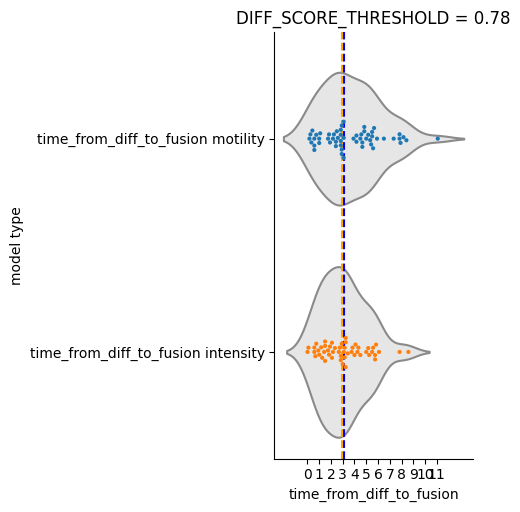

In [23]:
DIFF_SCORE_THRESHOLD = 0.78

df_fusion_props_mot = calc_fusion_properties(fusion_scores, "motility")  
df_fusion_props_int = calc_fusion_properties(fusion_scores, "intensity")  

for col in ["time_from_diff_to_fusion"]:   
    df_fusion_props_int["model type"] = col + " intensity"
    df_fusion_props_mot["model type"] = col + " motility"
    print("mean & median - motility","mean", df_fusion_props_mot[col].mean(),"median", df_fusion_props_mot[col].median())
    print("mean & median - intensity","mean",df_fusion_props_int[col].mean(),"median", df_fusion_props_int[col].median())
    
    print("motility diff time normality",normaltest(df_fusion_props_mot[col], nan_policy='omit'))
    print("actin diff time normality",normaltest(df_fusion_props_int[col], nan_policy='omit'))
    print("# cells motility", f"{len(df_fusion_props_mot)}/{fusion_scores['Spot track ID'].nunique()}")

    df = pd.concat([df_fusion_props_mot, df_fusion_props_int], ignore_index=True, axis=0)
    
    g = sns.catplot(data=df, x=col, y="model type", kind="violin", color=".9", inner=None)
    sns.swarmplot(data=df, x=col, y="model type", size=3)  
    
    plt.axvline(df_fusion_props_mot[col].median(), color='blue', linestyle='dashed')
    plt.axvline(df_fusion_props_int[col].median(), color='orange', linestyle='dashed')
    
    plt.xticks(range(int(df[col].max())+1)) 
    plt.title(f"DIFF_SCORE_THRESHOLD = {DIFF_SCORE_THRESHOLD}")
    plt.savefig(consts.storage_path + f"eps_figs/{col} distribution over time.eps", format="eps")
    plt.show()

In [ ]:
# differentiation threshold analysis

pearson_r_lst_mot = []
pearson_r_lst_int = []
threshold_range = np.arange(0.70, 0.9, 0.01)
for i in threshold_range:
    DIFF_SCORE_THRESHOLD = i
    df_fusion_props_mot_i = calc_fusion_properties(fusion_scores, "motility").dropna(subset=["diff_time", "fusion_time"])
    df_fusion_props_int_i = calc_fusion_properties(fusion_scores, "intensity").dropna(subset=["diff_time", "fusion_time"])
    
    p_mot, p_val_mot = scipy.stats.pearsonr(df_fusion_props_mot_i["diff_time"], df_fusion_props_mot_i["fusion_time"])
    p_int, p_val_int = scipy.stats.pearsonr(df_fusion_props_int_i["diff_time"], df_fusion_props_int_i["fusion_time"])
    
    pearson_r_lst_mot.append(p_mot)
    pearson_r_lst_int.append(p_int)
    
df_mot = pd.DataFrame({"pearson correlation":pearson_r_lst_mot, "diff threshold":np.round_(threshold_range,2), "model type": "motility"})
df_int = pd.DataFrame({"pearson correlation":pearson_r_lst_int, "diff threshold":np.round_(threshold_range,2), "model type": "intensity"})
df = pd.concat([df_mot, df_int], ignore_index=True)
sns.catplot(data=df, x="diff threshold", y="pearson correlation", kind="point", hue="model type")
plt.xticks(rotation=90)
plt.savefig(consts.storage_path + f"eps_figs/differentiation threshold analysis.eps", format="eps")
plt.show()

In [24]:
median_val = df_fusion_props_mot["time_from_diff_to_fusion"].median()
df_fusion_props_mot["dev_median_delta_diff_fusion"] = df_fusion_props_mot["time_from_diff_to_fusion"].apply(lambda x: x - median_val)

median_val = df_fusion_props_int["time_from_diff_to_fusion"].median()
df_fusion_props_int["dev_median_delta_diff_fusion"] = df_fusion_props_int["time_from_diff_to_fusion"].apply(lambda x: x - median_val)

def get_deviation_from_reg_line(data, x_col, y_col): 
    data = data.dropna(subset=[x_col, y_col])
    m, b = np.polyfit(data[x_col], data[y_col], 1)    
    data[f"dev_reg_{x_col}_{y_col}"] = data[[x_col, y_col]].apply(lambda x: m*x[x_col]+b - x[y_col] if x[x_col] !=np.nan else np.nan, axis=1)
    return data
df_fusion_props_mot = get_deviation_from_reg_line(df_fusion_props_mot, "diff_time", "fusion_time")
df_fusion_props_int = get_deviation_from_reg_line(df_fusion_props_int, "diff_time", "fusion_time")

In [24]:
def plot_corr(x_col, y_col, mot_data, int_data, title, path=None, plot_reg_line=True):
    mot_data = mot_data.dropna()
    int_data = int_data.dropna()
    
    plt.scatter(mot_data[x_col], mot_data[y_col], color="orange", label= "motility")
    plt.scatter(int_data[x_col], int_data[y_col], color="brown", label="intensity")
    
    if plot_reg_line:
        m_mot, b_mot = np.polyfit(mot_data[x_col], mot_data[y_col], 1)
        m_int, b_int = np.polyfit(int_data[x_col], int_data[y_col], 1)
        plt.plot(mot_data[x_col], m_mot*mot_data[x_col]+b_mot, color="orange")
        plt.plot(int_data[x_col], m_int*int_data[x_col]+b_int, color="brown")
    else:
        plt.axhline(0, color='gray', linestyle='dashed')

    
    p_mot, p_val_mot = scipy.stats.pearsonr(mot_data[x_col], mot_data[y_col])
    p_int, p_val_int = scipy.stats.pearsonr(int_data[x_col], int_data[y_col])
    
    plt.title(title + f" \npearson \nmotility- coeff={round(p_mot,8)} p_val={round(p_val_mot,8)},\nintensity- ceff={round(p_int,3)}, p_val={round(p_val_int,8)}") #, intensity= {round(p_int,3)}
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    if path:
        plt.savefig(path, format="eps")
    plt.show()    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


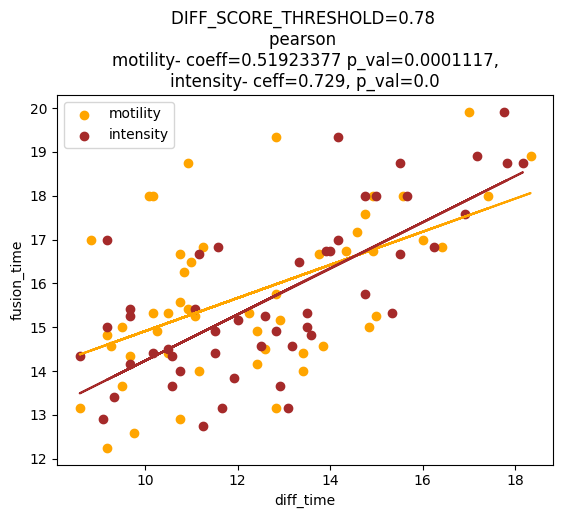

In [25]:
title = f"DIFF_SCORE_THRESHOLD={DIFF_SCORE_THRESHOLD}"
plot_corr("diff_time", "fusion_time", df_fusion_props_mot, df_fusion_props_int, title, path = consts.storage_path + "eps_figs/fusion time over diff time.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


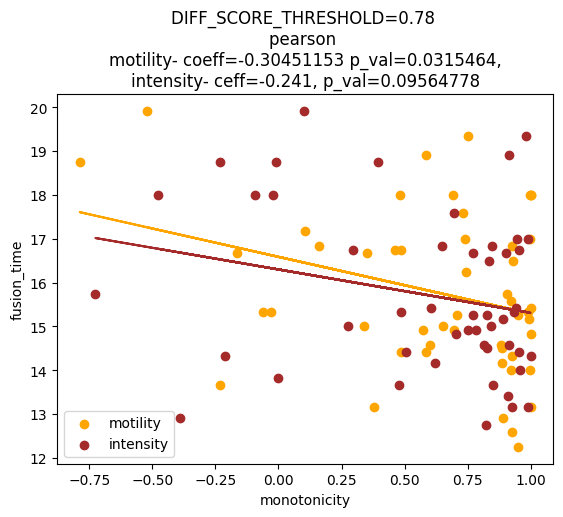

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


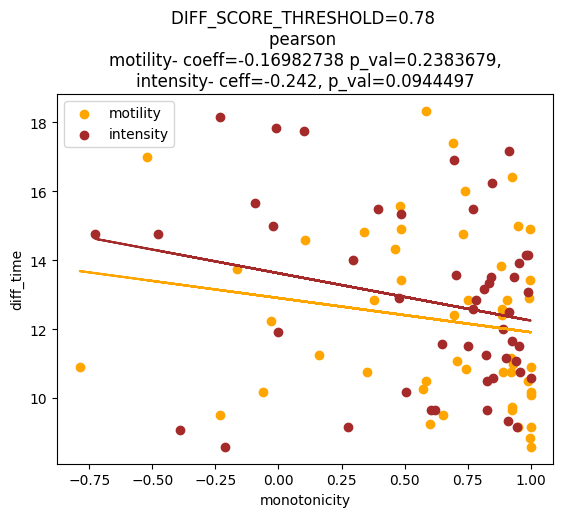

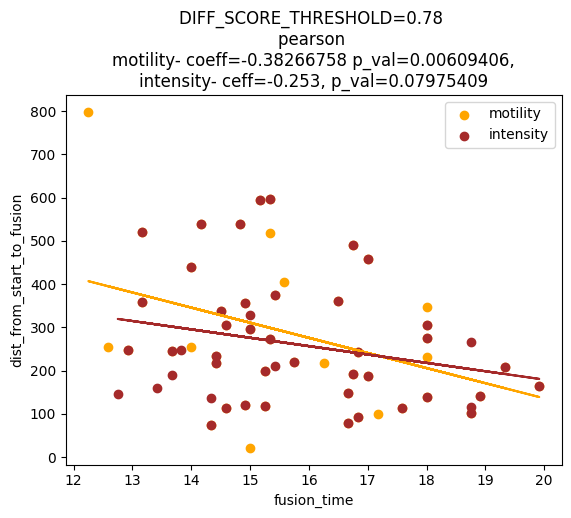

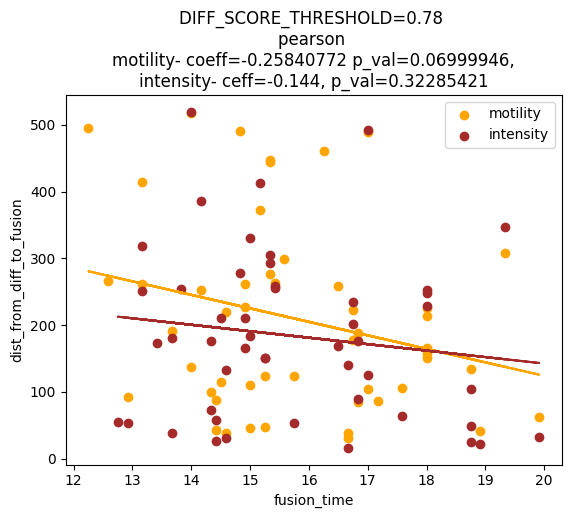

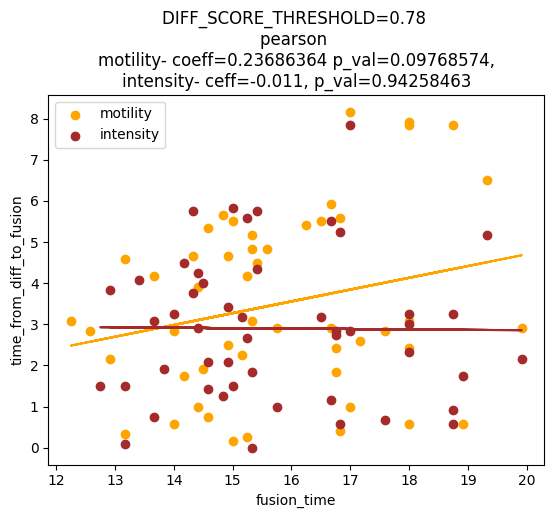

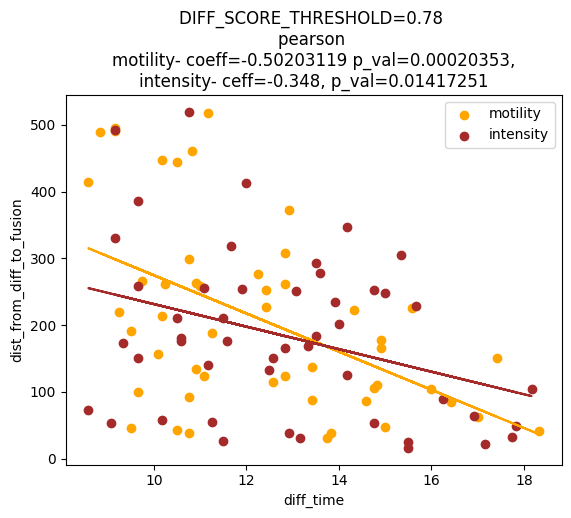

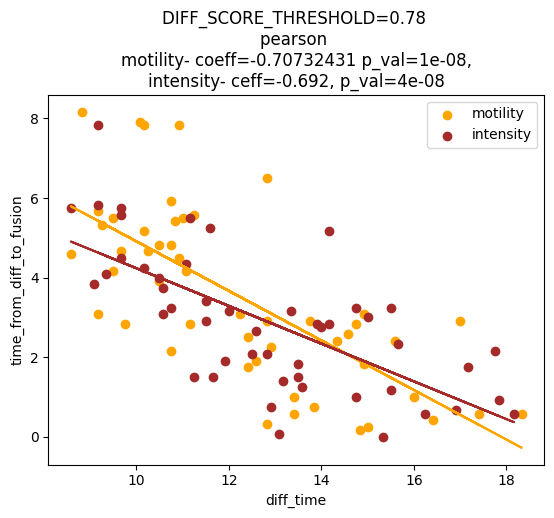

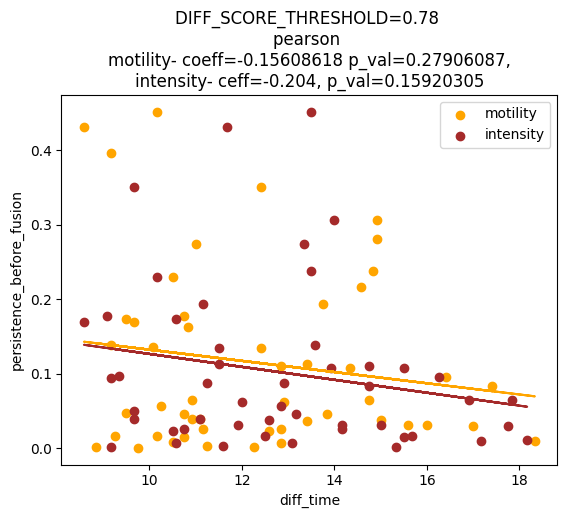

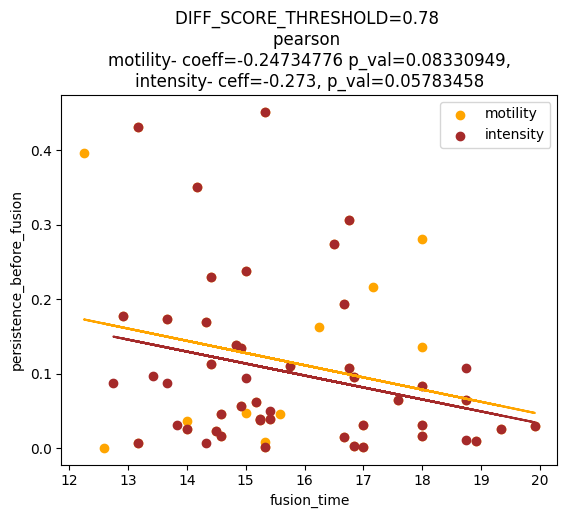

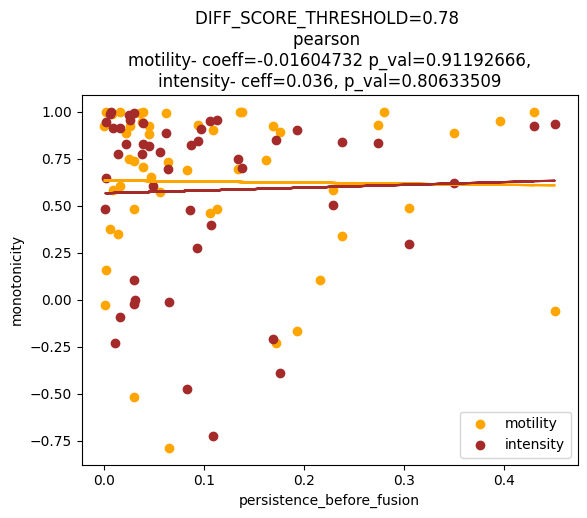

In [27]:
plot_corr("monotonicity", "fusion_time", df_fusion_props_mot, df_fusion_props_int, title, path = consts.storage_path + "eps_figs/monotonicity over fusion time.eps")
plot_corr("monotonicity", "diff_time", df_fusion_props_mot, df_fusion_props_int, title, path = consts.storage_path + "eps_figs/monotonicity over diff time.eps")

plot_corr("fusion_time", "dist_from_start_to_fusion", df_fusion_props_mot, df_fusion_props_int, title)
plot_corr("fusion_time", "dist_from_diff_to_fusion", df_fusion_props_mot, df_fusion_props_int, title)
plot_corr("fusion_time", "time_from_diff_to_fusion", df_fusion_props_mot, df_fusion_props_int, title)

plot_corr("diff_time", "dist_from_diff_to_fusion", df_fusion_props_mot, df_fusion_props_int, title)
plot_corr("diff_time", "time_from_diff_to_fusion", df_fusion_props_mot, df_fusion_props_int, title)

plot_corr("diff_time", "persistence_before_fusion", df_fusion_props_mot, df_fusion_props_int, title)
plot_corr("fusion_time", "persistence_before_fusion", df_fusion_props_mot, df_fusion_props_int, title)
plot_corr("persistence_before_fusion", "monotonicity", df_fusion_props_mot, df_fusion_props_int, title)

217.0 rolling w=1
monotonicity motility 0.8329
monotonicity intensity 0.8967
kendalltau motility 0.6487
kendalltau intensity 0.6885
rolling_mean_spearman intensity 0.6468301768171002
rolling_mean_spearman motility 0.6486759555204493


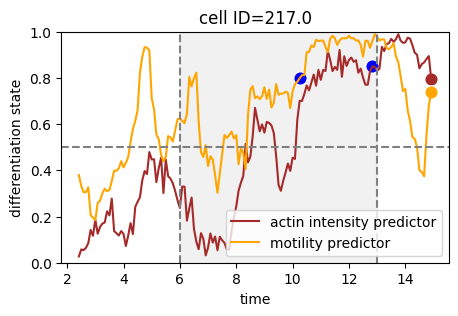

9406.0 rolling w=1
monotonicity motility 0.1412
monotonicity intensity -0.4068
kendalltau motility 0.1109
kendalltau intensity -0.2964
rolling_mean_spearman intensity -0.31189824682354506
rolling_mean_spearman motility -0.02662815546776199


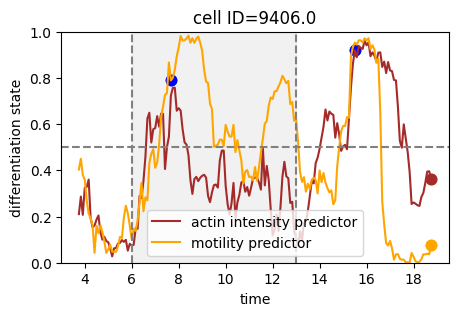

18989.0 rolling w=1
monotonicity motility 0.7484
monotonicity intensity 0.6938
kendalltau motility 0.5782
kendalltau intensity 0.5266
rolling_mean_spearman intensity 0.34420987586607826
rolling_mean_spearman motility 0.37067888530492504


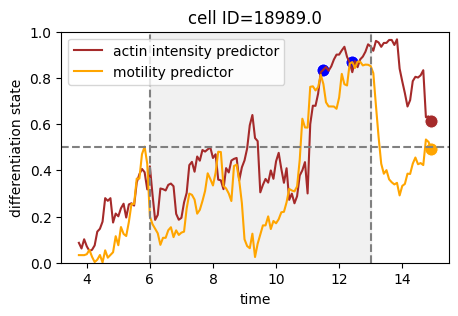

16771.0 rolling w=1
monotonicity motility 0.281
monotonicity intensity 0.5713
kendalltau motility 0.2168
kendalltau intensity 0.3473
rolling_mean_spearman intensity 0.053916071407365936
rolling_mean_spearman motility 0.06745838463178312


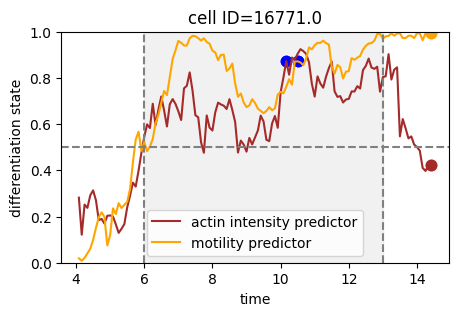

12526.0 rolling w=1
monotonicity motility 0.4497
monotonicity intensity 0.7124
kendalltau motility 0.3064
kendalltau intensity 0.5322
rolling_mean_spearman intensity 0.3716692880892131
rolling_mean_spearman motility 0.11505782592253623


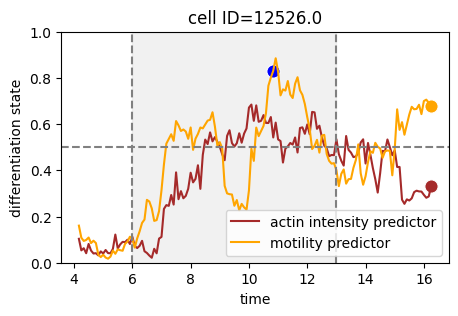

11178.0 rolling w=1
monotonicity motility 0.6775
monotonicity intensity 0.6301
kendalltau motility 0.5204
kendalltau intensity 0.3692
rolling_mean_spearman intensity 0.08735311403857911
rolling_mean_spearman motility 0.3638872422706712


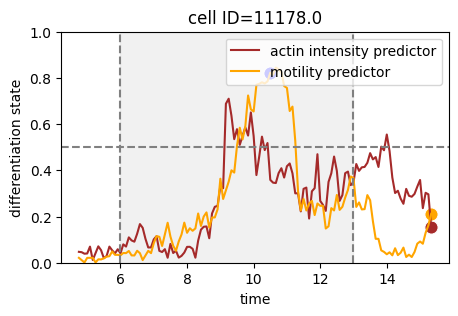

9241.0 rolling w=1
monotonicity motility 0.1143
monotonicity intensity 0.9439
kendalltau motility 0.0728
kendalltau intensity 0.7994
rolling_mean_spearman intensity 0.8570160503090392
rolling_mean_spearman motility 0.20809758959369098


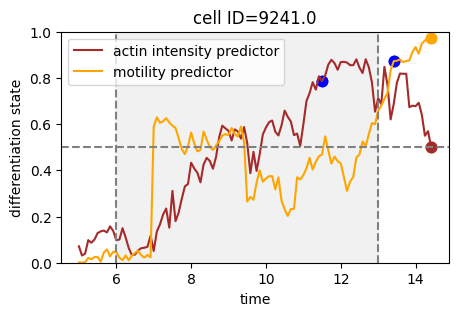

1394.0 rolling w=1
monotonicity motility 0.6842
monotonicity intensity 0.8851
kendalltau motility 0.3956
kendalltau intensity 0.7073
rolling_mean_spearman intensity 0.5979427322284928
rolling_mean_spearman motility 0.21118149070969053


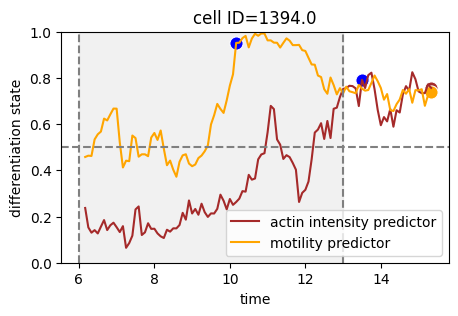

27217.0 rolling w=1
monotonicity motility 0.2228
monotonicity intensity 0.3288
kendalltau motility 0.0693
kendalltau intensity 0.2274
rolling_mean_spearman intensity 0.08393738615276825
rolling_mean_spearman motility -0.16182139907749607


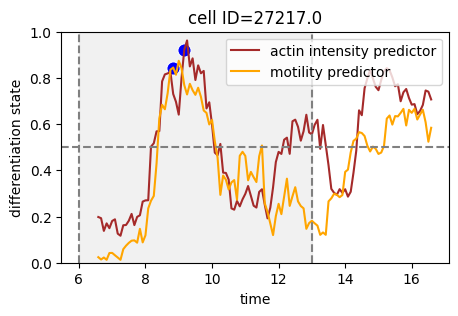

16991.0 rolling w=1
monotonicity motility 0.9809
monotonicity intensity 0.9009
kendalltau motility 0.9014
kendalltau intensity 0.7391
rolling_mean_spearman intensity 0.7291985941418109
rolling_mean_spearman motility 0.9114284834852093


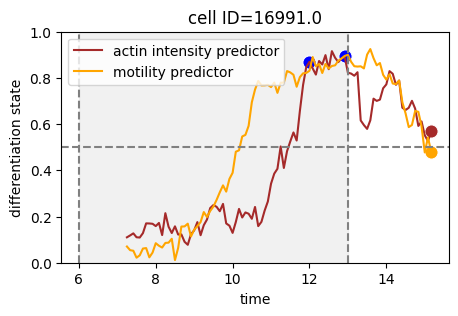

16003.0 rolling w=1
monotonicity motility 0.8512
monotonicity intensity 0.8548
kendalltau motility 0.6371
kendalltau intensity 0.6786
rolling_mean_spearman intensity 0.6564597222677324
rolling_mean_spearman motility 0.7954172084016828


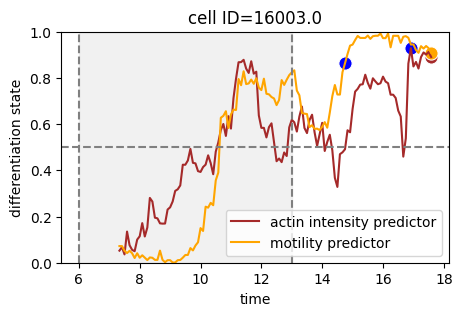

14919.0 rolling w=1
monotonicity motility 0.6031
monotonicity intensity 0.3767
kendalltau motility 0.3763
kendalltau intensity 0.2713
rolling_mean_spearman intensity 0.2224724386153345
rolling_mean_spearman motility 0.18743839650449012


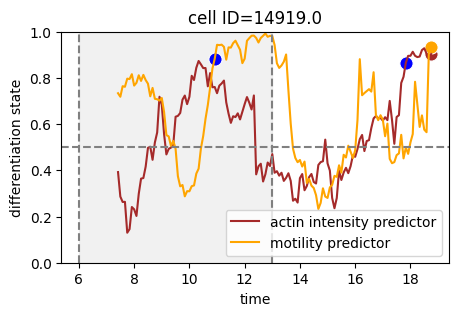

3656.0 rolling w=1
monotonicity motility -0.9219
monotonicity intensity 0.3597
kendalltau motility -0.7589
kendalltau intensity 0.1582
rolling_mean_spearman intensity 0.2816543094469014
rolling_mean_spearman motility -0.8729496658469766


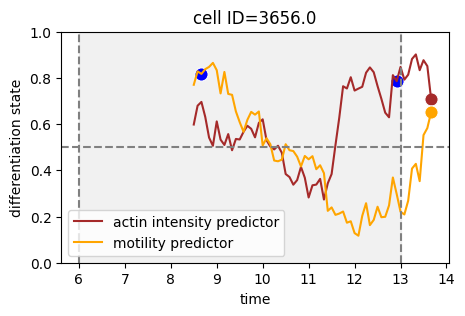

16042.0 rolling w=1
monotonicity motility -0.6687
monotonicity intensity 0.8991
kendalltau motility -0.4444
kendalltau intensity 0.7333
rolling_mean_spearman intensity 0.8284809812674168
rolling_mean_spearman motility -0.7000743515887012


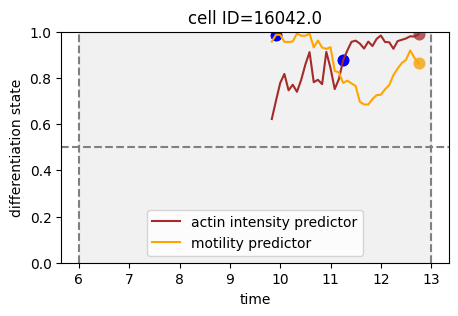

6208.0 rolling w=1
monotonicity motility 0.5567
monotonicity intensity -0.6069
kendalltau motility 0.4138
kendalltau intensity -0.3793
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


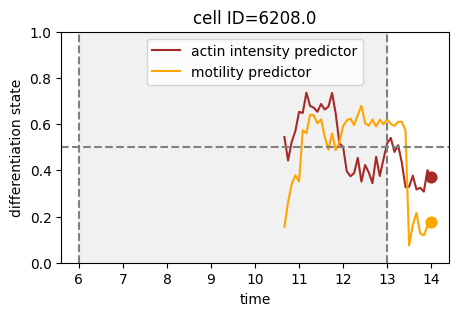

14831.0 rolling w=1
monotonicity motility 0.5333
monotonicity intensity 0.6167
kendalltau motility 0.3889
kendalltau intensity 0.5
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


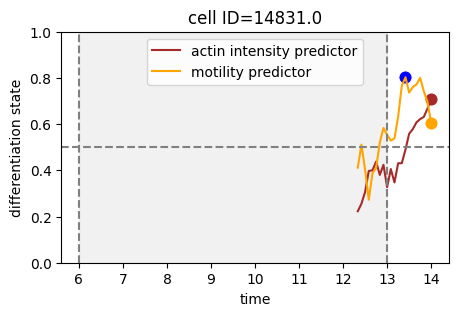

19228.0 rolling w=1
monotonicity motility nan
monotonicity intensity nan
kendalltau motility nan
kendalltau intensity nan
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


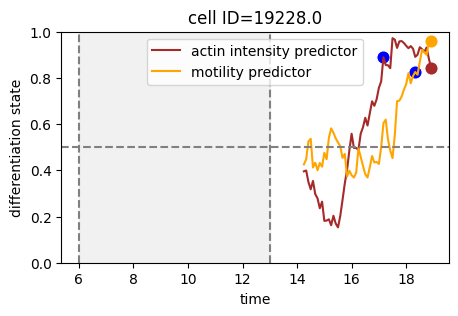

10528.0 rolling w=1
monotonicity motility 0.5539
monotonicity intensity 0.9231
kendalltau motility 0.4303
kendalltau intensity 0.7719
rolling_mean_spearman intensity 0.6686093657973096
rolling_mean_spearman motility 0.3199226579422794


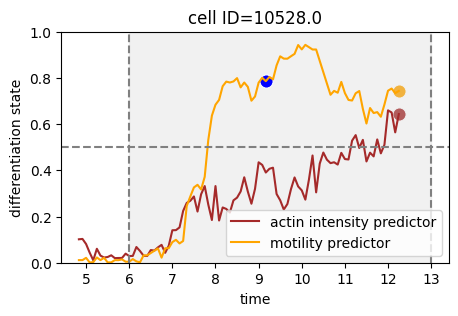

8076.0 rolling w=1
monotonicity motility nan
monotonicity intensity nan
kendalltau motility nan
kendalltau intensity nan
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


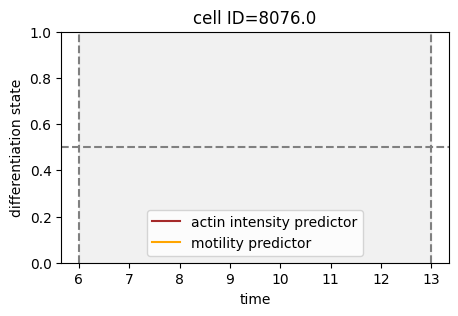

23847.0 rolling w=1
monotonicity motility 0.8752
monotonicity intensity 0.9126
kendalltau motility 0.6446
kendalltau intensity 0.7491
rolling_mean_spearman intensity 0.9083767484205622
rolling_mean_spearman motility 0.7884614077273209


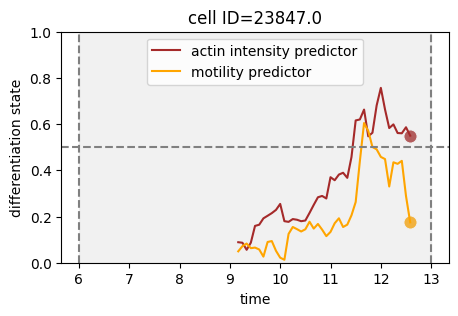

16348.0 rolling w=1
monotonicity motility 0.2444
monotonicity intensity -0.6236
kendalltau motility 0.2497
kendalltau intensity -0.4386
rolling_mean_spearman intensity -0.4176255117113791
rolling_mean_spearman motility 0.3460004876460065


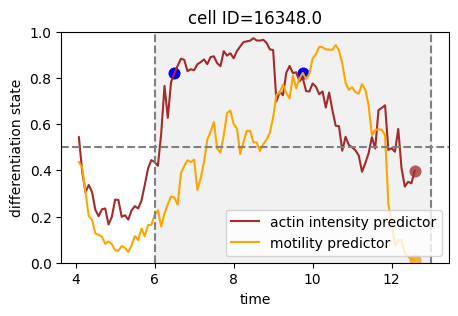

23080.0 rolling w=1
monotonicity motility -0.4041
monotonicity intensity 0.1404
kendalltau motility -0.3242
kendalltau intensity 0.12
rolling_mean_spearman intensity 0.09861423223003041
rolling_mean_spearman motility -0.37025064810891445


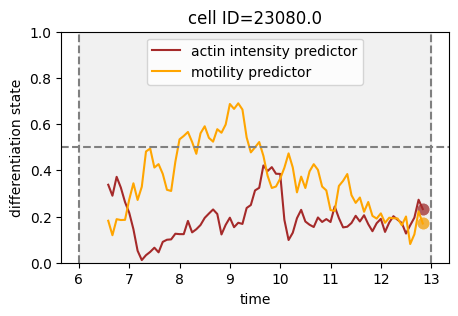

10879.0 rolling w=1
monotonicity motility 0.0402
monotonicity intensity 0.7246
kendalltau motility 0.1256
kendalltau intensity 0.5267
rolling_mean_spearman intensity 0.48416022293307287
rolling_mean_spearman motility 0.2462666389441677


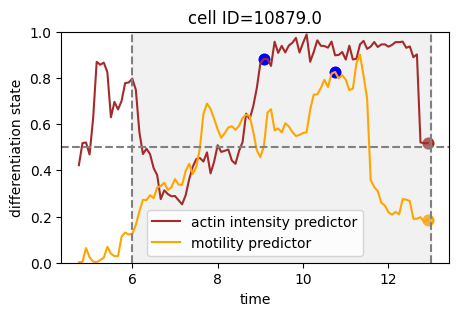

16082.0 rolling w=1
monotonicity motility -0.1091
monotonicity intensity 0.2455
kendalltau motility -0.0909
kendalltau intensity 0.2
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


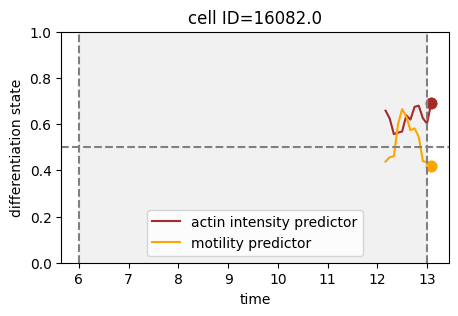

16091.0 rolling w=1
monotonicity motility 0.3394
monotonicity intensity 0.9615
kendalltau motility 0.2566
kendalltau intensity 0.8406
rolling_mean_spearman intensity 0.9013817889226697
rolling_mean_spearman motility 0.3206928749613055


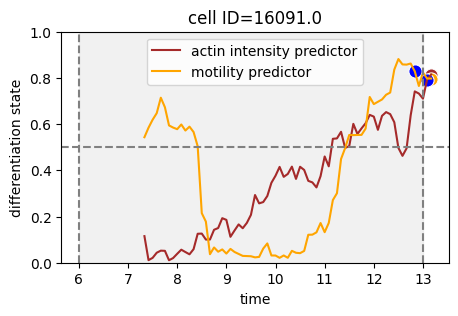

17022.0 rolling w=1
monotonicity motility 0.3049
monotonicity intensity 0.9035
kendalltau motility 0.2133
kendalltau intensity 0.7275
rolling_mean_spearman intensity 0.8463411910904408
rolling_mean_spearman motility -0.19904647519004384


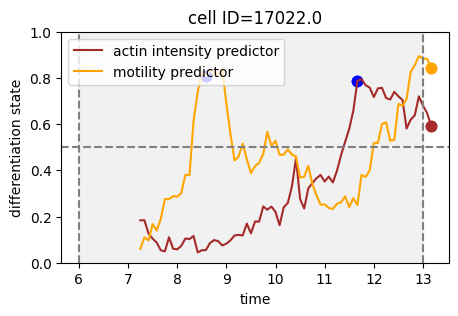

2764.0 rolling w=1
monotonicity motility 0.1072
monotonicity intensity 0.4231
kendalltau motility 0.0846
kendalltau intensity 0.2812
rolling_mean_spearman intensity 0.11702721245870018
rolling_mean_spearman motility 0.0100703109281553


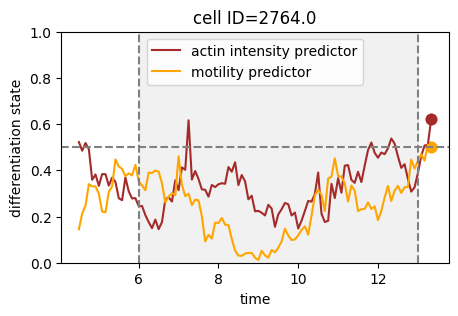

13781.0 rolling w=1
monotonicity motility 0.7161
monotonicity intensity 0.5605
kendalltau motility 0.5249
kendalltau intensity 0.403
rolling_mean_spearman intensity 0.27222462573275297
rolling_mean_spearman motility 0.38908788023093593


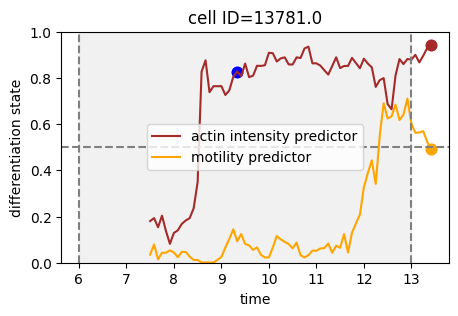

12600.0 rolling w=1
monotonicity motility -0.1327
monotonicity intensity 0.6033
kendalltau motility -0.1788
kendalltau intensity 0.4154
rolling_mean_spearman intensity 0.11508732328812132
rolling_mean_spearman motility -0.2885148026395359


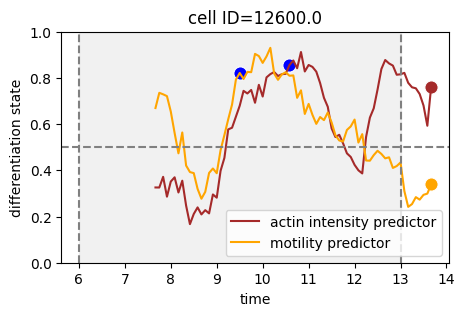

4657.0 rolling w=1
monotonicity motility 0.8994
monotonicity intensity 0.9627
kendalltau motility 0.7139
kendalltau intensity 0.8387
rolling_mean_spearman intensity 0.8377515334315397
rolling_mean_spearman motility 0.663911379863895


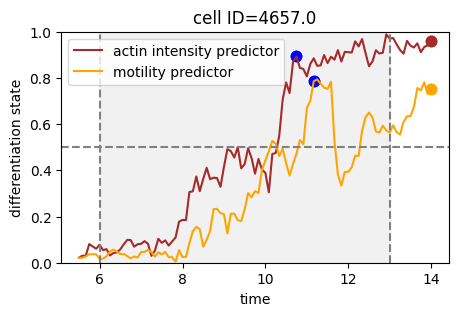

6993.0 rolling w=1
monotonicity motility 0.8755
monotonicity intensity 0.3228
kendalltau motility 0.7106
kendalltau intensity 0.2308
rolling_mean_spearman intensity 0.11391208157096341
rolling_mean_spearman motility 0.5469321535111642


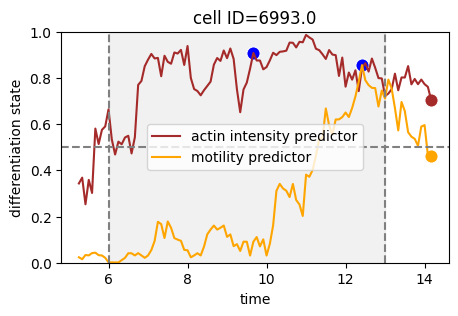

11105.0 rolling w=1
monotonicity motility 0.454
monotonicity intensity 0.225
kendalltau motility 0.3423
kendalltau intensity 0.1317
rolling_mean_spearman intensity 0.10947639163467142
rolling_mean_spearman motility 0.3498373292648865


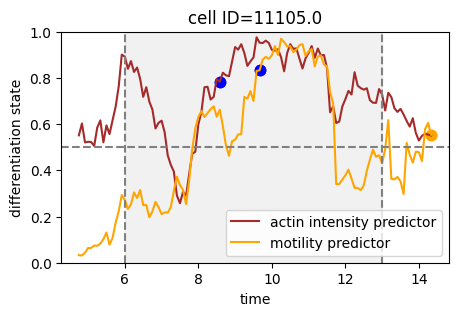

7791.0 rolling w=1
monotonicity motility 0.331
monotonicity intensity -0.3624
kendalltau motility 0.2508
kendalltau intensity -0.2508
rolling_mean_spearman intensity -0.6683206502899023
rolling_mean_spearman motility 0.0020270888871211446


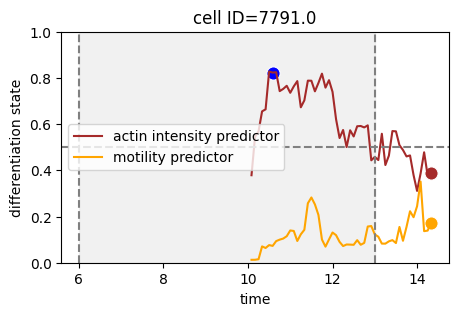

3637.0 rolling w=1
monotonicity motility 0.8939
monotonicity intensity 0.3147
kendalltau motility 0.7429
kendalltau intensity 0.144
rolling_mean_spearman intensity -0.06772479857744823
rolling_mean_spearman motility 0.5980890940650029


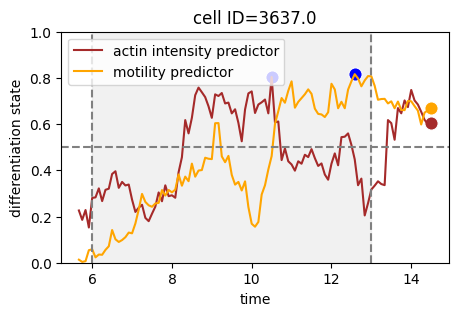

3125.0 rolling w=1
monotonicity motility nan
monotonicity intensity nan
kendalltau motility nan
kendalltau intensity nan
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


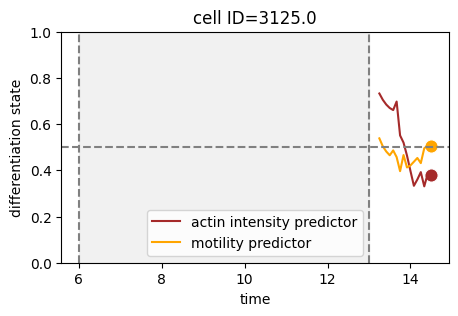

27879.0 rolling w=1
monotonicity motility 0.7934
monotonicity intensity 0.7005
kendalltau motility 0.6127
kendalltau intensity 0.5072
rolling_mean_spearman intensity 0.4859038652762383
rolling_mean_spearman motility 0.5716994965344923


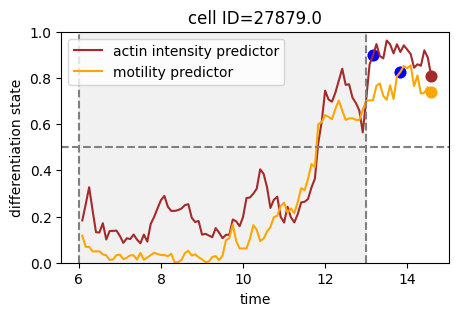

12195.0 rolling w=1
monotonicity motility 0.1526
monotonicity intensity 0.3876
kendalltau motility 0.0936
kendalltau intensity 0.2471
rolling_mean_spearman intensity 0.09472784321531334
rolling_mean_spearman motility -0.09666231693185193


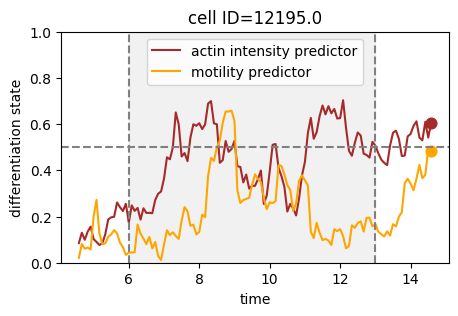

28843.0 rolling w=1
monotonicity motility 0.2829
monotonicity intensity 0.755
kendalltau motility 0.1742
kendalltau intensity 0.5143
rolling_mean_spearman intensity 0.2823765960170982
rolling_mean_spearman motility 0.20677621474744604


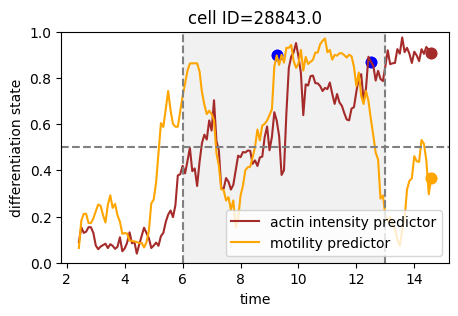

5490.0 rolling w=1
monotonicity motility 0.2961
monotonicity intensity 0.525
kendalltau motility 0.1958
kendalltau intensity 0.3505
rolling_mean_spearman intensity 0.18310981231066367
rolling_mean_spearman motility 0.08460274772778933


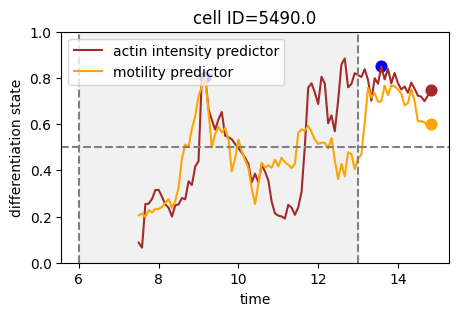

20857.0 rolling w=1
monotonicity motility -0.0644
monotonicity intensity 0.5903
kendalltau motility 0.0119
kendalltau intensity 0.4559
rolling_mean_spearman intensity 0.2550157483978961
rolling_mean_spearman motility 0.09912091634423759


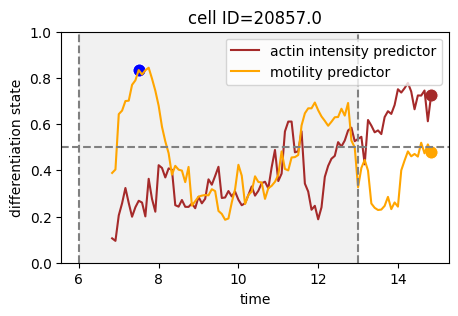

4959.0 rolling w=1
monotonicity motility 0.348
monotonicity intensity -0.1646
kendalltau motility 0.2706
kendalltau intensity -0.1098
rolling_mean_spearman intensity -0.17978850808590383
rolling_mean_spearman motility 0.12964508754285073


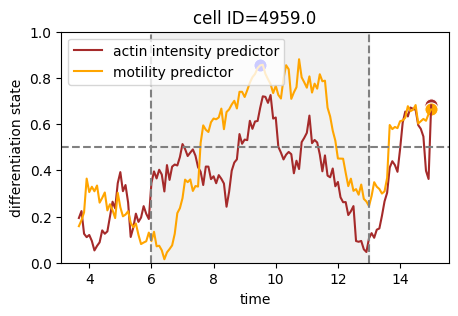

8662.0 rolling w=1
monotonicity motility -0.1118
monotonicity intensity 0.7968
kendalltau motility -0.1104
kendalltau intensity 0.5727
rolling_mean_spearman intensity 0.6357945533311086
rolling_mean_spearman motility -0.19460826406082132


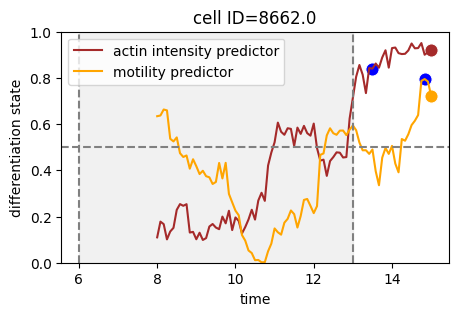

10483.0 rolling w=1
monotonicity motility -0.3446
monotonicity intensity 0.3943
kendalltau motility -0.2028
kendalltau intensity 0.2739
rolling_mean_spearman intensity 0.1191525194629501
rolling_mean_spearman motility -0.09118328604819491


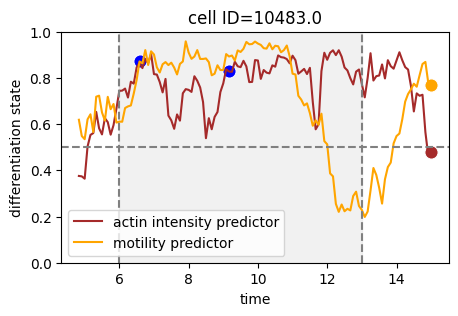

13388.0 rolling w=1
monotonicity motility 0.8917
monotonicity intensity 0.4525
kendalltau motility 0.7015
kendalltau intensity 0.2915
rolling_mean_spearman intensity 0.18344604454891228
rolling_mean_spearman motility 0.7089521160786277


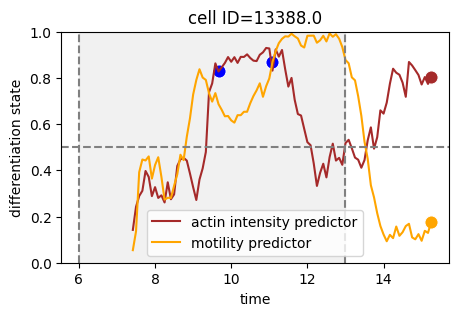

28929.0 rolling w=1
monotonicity motility 0.9288
monotonicity intensity 0.7852
kendalltau motility 0.7612
kendalltau intensity 0.5905
rolling_mean_spearman intensity 0.4577743587486066
rolling_mean_spearman motility 0.6975528959562375


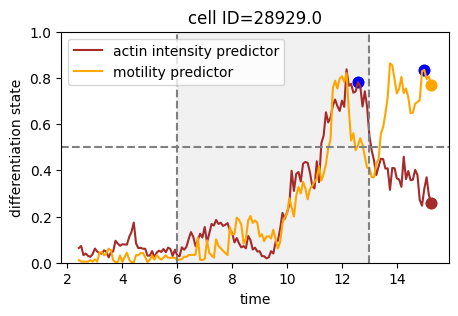

22402.0 rolling w=1
monotonicity motility nan
monotonicity intensity nan
kendalltau motility nan
kendalltau intensity nan
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


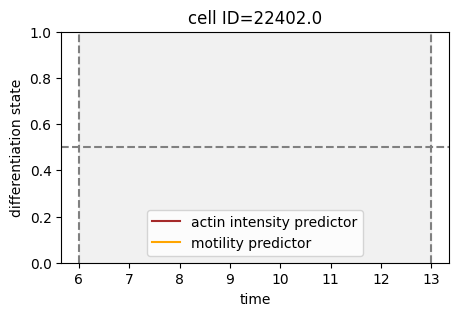

10110.0 rolling w=1
monotonicity motility 0.3425
monotonicity intensity 0.4066
kendalltau motility 0.2418
kendalltau intensity 0.2895
rolling_mean_spearman intensity 0.175072165282516
rolling_mean_spearman motility 0.04446088852789818


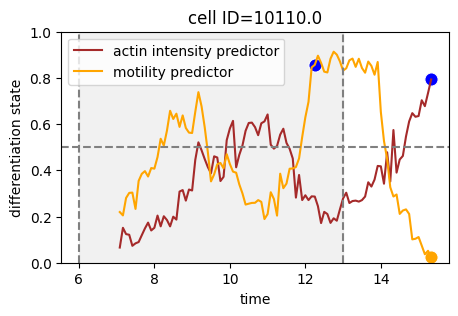

25513.0 rolling w=1
monotonicity motility 0.0837
monotonicity intensity 0.4628
kendalltau motility 0.0272
kendalltau intensity 0.3074
rolling_mean_spearman intensity 0.38641583945898306
rolling_mean_spearman motility 0.14095097834470052


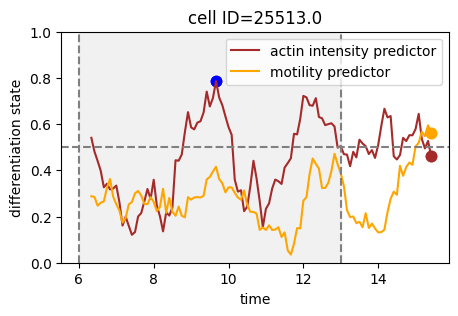

6405.0 rolling w=1
monotonicity motility 0.163
monotonicity intensity 0.2911
kendalltau motility 0.1301
kendalltau intensity 0.1586
rolling_mean_spearman intensity 0.3326420534850405
rolling_mean_spearman motility -0.04941831480974094


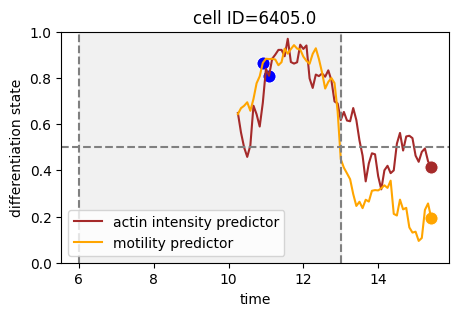

6004.0 rolling w=1
monotonicity motility 0.7158
monotonicity intensity -0.365
kendalltau motility 0.5419
kendalltau intensity -0.2315
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


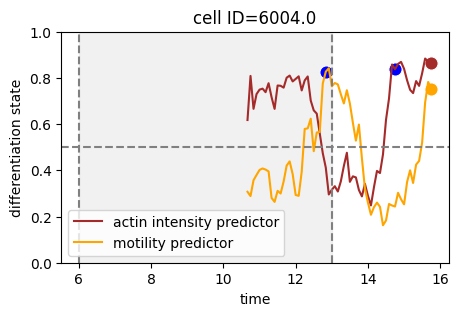

12487.0 rolling w=1
monotonicity motility 0.9584
monotonicity intensity 0.7395
kendalltau motility 0.8252
kendalltau intensity 0.555
rolling_mean_spearman intensity 0.3564174040836844
rolling_mean_spearman motility 0.874021639836627


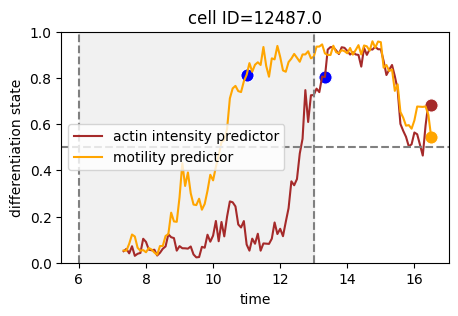

5716.0 rolling w=1
monotonicity motility 0.1281
monotonicity intensity 0.8568
kendalltau motility 0.1591
kendalltau intensity 0.6588
rolling_mean_spearman intensity 0.670455652694505
rolling_mean_spearman motility 0.4554919594631844


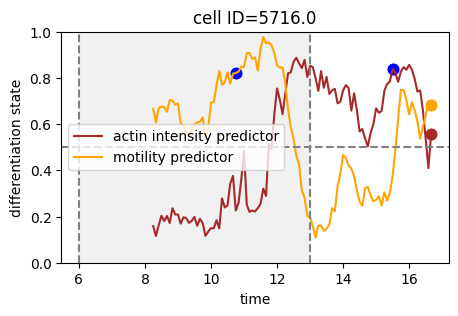

5453.0 rolling w=1
monotonicity motility -0.5784
monotonicity intensity 0.9094
kendalltau motility -0.2917
kendalltau intensity 0.7533
rolling_mean_spearman intensity 0.8989405899284479
rolling_mean_spearman motility -0.4874809961373356


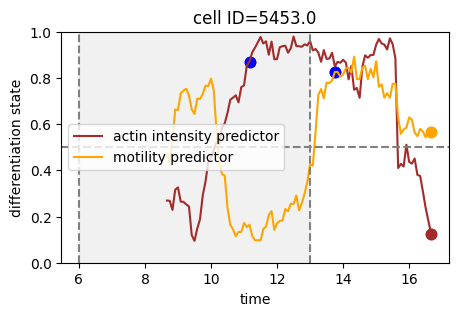

21523.0 rolling w=1
monotonicity motility 0.5635
monotonicity intensity 0.8819
kendalltau motility 0.386
kendalltau intensity 0.7025
rolling_mean_spearman intensity 0.7140573624588331
rolling_mean_spearman motility 0.15581529410545564


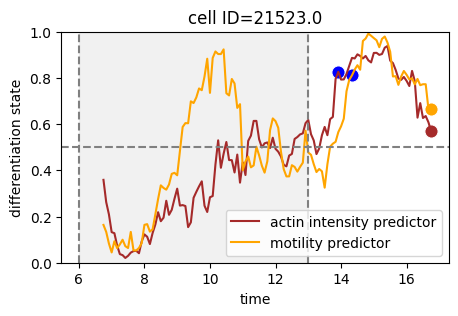

7466.0 rolling w=1
monotonicity motility -0.0074
monotonicity intensity 0.4434
kendalltau motility -0.0328
kendalltau intensity 0.2859
rolling_mean_spearman intensity 0.30688062231471736
rolling_mean_spearman motility 0.20389170293294998


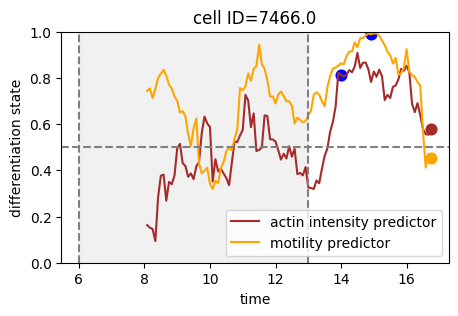

17201.0 rolling w=1
monotonicity motility 0.7228
monotonicity intensity 0.8318
kendalltau motility 0.5618
kendalltau intensity 0.6257
rolling_mean_spearman intensity 0.4705009643407826
rolling_mean_spearman motility 0.26039396556020905


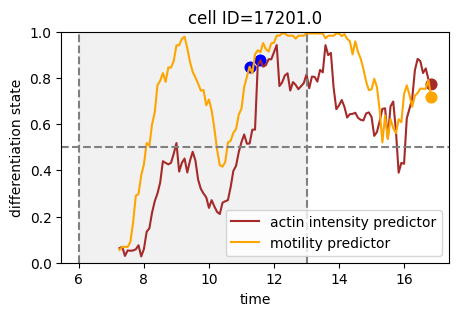

8598.0 rolling w=1
monotonicity motility 0.8999
monotonicity intensity 0.7197
kendalltau motility 0.7202
kendalltau intensity 0.5366
rolling_mean_spearman intensity 0.36066667044155737
rolling_mean_spearman motility 0.8370442974838296


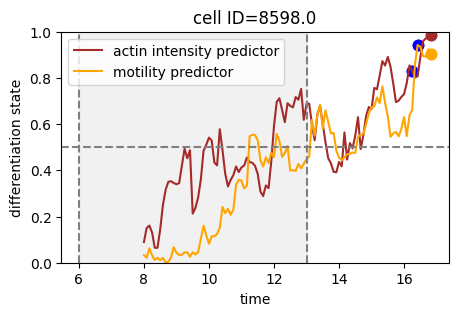

6749.0 rolling w=1
monotonicity motility 1.0
monotonicity intensity 1.0
kendalltau motility 1.0
kendalltau intensity 1.0
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


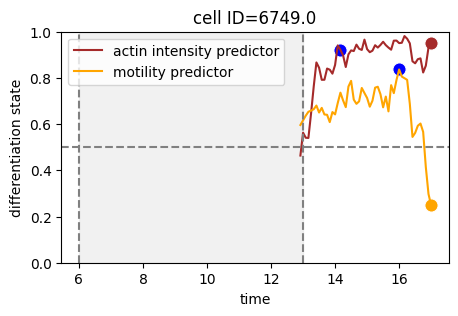

23903.0 rolling w=1
monotonicity motility 0.0285
monotonicity intensity 0.2028
kendalltau motility 0.1389
kendalltau intensity 0.1704
rolling_mean_spearman intensity 0.10570234964596258
rolling_mean_spearman motility 0.05818883376552467


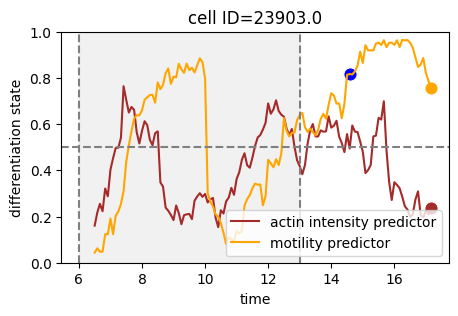

23888.0 rolling w=1
monotonicity motility 0.1618
monotonicity intensity -0.7655
kendalltau motility 0.0453
kendalltau intensity -0.5504
rolling_mean_spearman intensity -0.6679884570184288
rolling_mean_spearman motility -0.044171323835667714


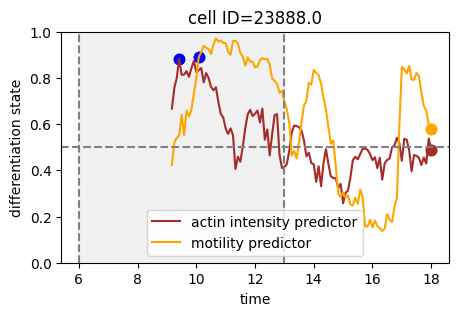

13962.0 rolling w=1
monotonicity motility 0.4545
monotonicity intensity -0.4855
kendalltau motility 0.2588
kendalltau intensity -0.327
rolling_mean_spearman intensity -0.23430252679568117
rolling_mean_spearman motility 0.12909630003868758


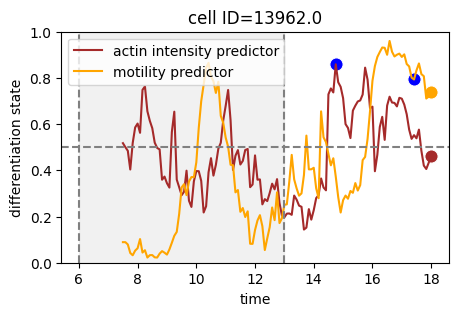

6449.0 rolling w=1
monotonicity motility 0.2937
monotonicity intensity 0.1333
kendalltau motility 0.2202
kendalltau intensity 0.0154
rolling_mean_spearman intensity -0.5069757864395406
rolling_mean_spearman motility 0.4840368512625532


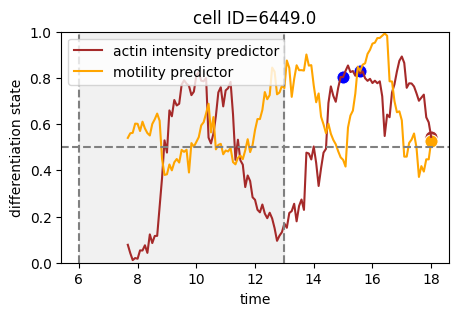

21932.0 rolling w=1
monotonicity motility -0.7466
monotonicity intensity -0.7235
kendalltau motility -0.5243
kendalltau intensity -0.5243
rolling_mean_spearman intensity -0.7436444482723145
rolling_mean_spearman motility -0.7953758851152828


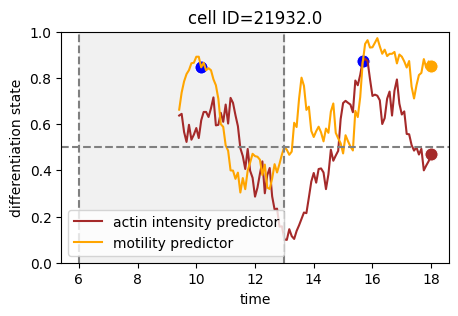

19414.0 rolling w=1
monotonicity motility -0.8
monotonicity intensity 0.4
kendalltau motility -0.6667
kendalltau intensity 0.3333
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


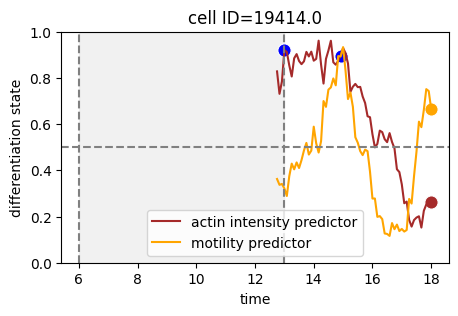

5595.0 rolling w=1
monotonicity motility nan
monotonicity intensity nan
kendalltau motility nan
kendalltau intensity nan
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


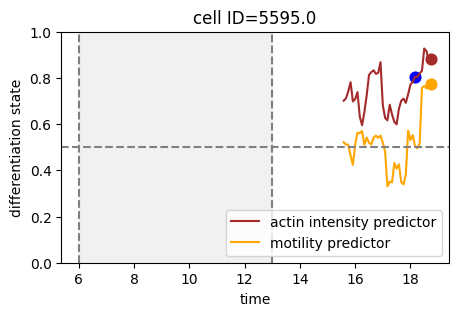

19875.0 rolling w=1
monotonicity motility 0.6396
monotonicity intensity 0.4901
kendalltau motility 0.5165
kendalltau intensity 0.3187
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


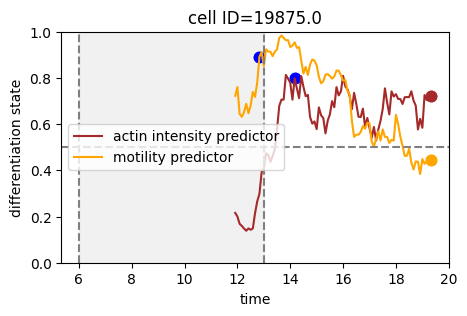

14320.0 rolling w=1
monotonicity motility -0.6882
monotonicity intensity -0.7383
kendalltau motility -0.5045
kendalltau intensity -0.4775
rolling_mean_spearman intensity -0.8542137279952372
rolling_mean_spearman motility -0.6842710725229655


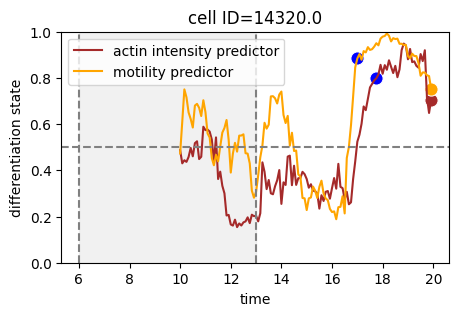

7339.0 rolling w=1
monotonicity motility 0.4949
monotonicity intensity -0.6063
kendalltau motility 0.3629
kendalltau intensity -0.375
rolling_mean_spearman intensity -0.6376423160499799
rolling_mean_spearman motility 0.6432731621380814


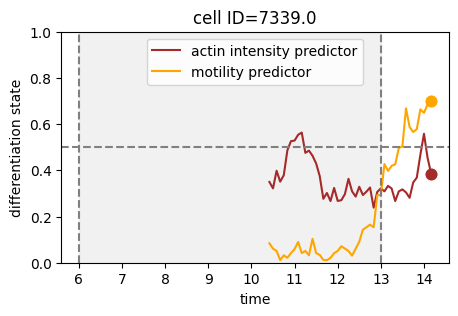

21202.0 rolling w=1
monotonicity motility 0.0077
monotonicity intensity -0.4231
kendalltau motility -0.1333
kendalltau intensity -0.28
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


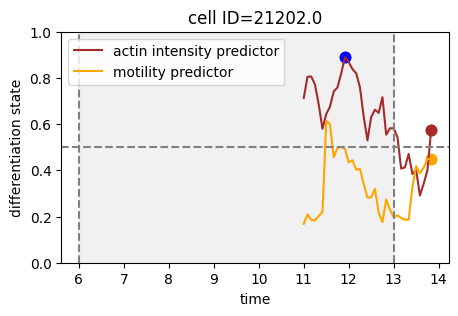

7127.0 rolling w=1
monotonicity motility -0.5965
monotonicity intensity 0.6892
kendalltau motility -0.3541
kendalltau intensity 0.4935
rolling_mean_spearman intensity 0.620429310792458
rolling_mean_spearman motility -0.44931287981153806


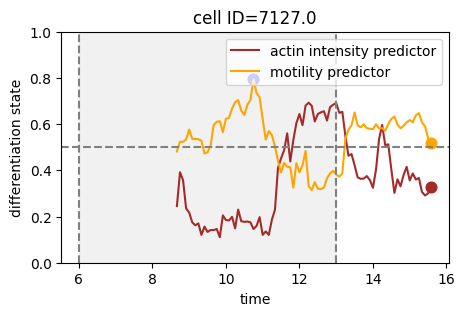

6401.0 rolling w=1
monotonicity motility nan
monotonicity intensity nan
kendalltau motility nan
kendalltau intensity nan
rolling_mean_spearman intensity nan
rolling_mean_spearman motility nan


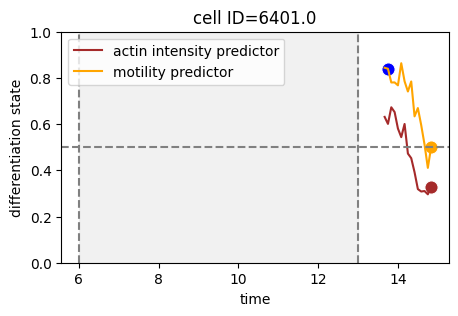

In [31]:
# plot single cell differentiation trajectory with fusion time

def plot_single_cell_fusion_time(track_id, mot_diff_time, int_diff_time, rolling_w=1):    
    print(track_id, f"rolling w={rolling_w}")
    track_data = fusion_scores[(fusion_scores["Spot track ID"]==track_id)]
    track_data["score_intensity"] = track_data["score_intensity"].rolling(rolling_w).mean()
    track_data["score_motility"] = track_data["score_motility"].rolling(rolling_w).mean()
    
    # cut track after fusion time
    track_data = track_data[(track_data["time"]<=track_data["fusion_time"])]
    
    if len(track_data)>1:
        fig = plt.subplots(figsize=(5,3))
        print("monotonicity motility", get_monotonicity(track_data, "motility", (6,13), rolling_window=rolling_w))
        print("monotonicity intensity", get_monotonicity(track_data, "intensity", (6,13), rolling_window=rolling_w))
        print("kendalltau motility",get_kendalltau(track_data, "motility", (6,13), rolling_window=rolling_w))
        print("kendalltau intensity",get_kendalltau(track_data, "intensity", (6,13), rolling_window=rolling_w))
        
        print("rolling_mean_spearman intensity",rolling_corr_mean_value(track_data, "intensity", (6,13), rolling_window=30, corr_metric="spearman"))
        print("rolling_mean_spearman motility",rolling_corr_mean_value(track_data, "motility", (6,13), rolling_window=30, corr_metric="spearman"))
    
    
        sns.lineplot(x=track_data["time"], y="score_intensity", data=track_data, label="actin intensity predictor", color="brown")
        sns.scatterplot(x=track_data["fusion_time"], y="score_intensity", data=track_data[(track_data["time"]==track_data["fusion_time"])], color="brown", s=90)

        sns.lineplot(x=track_data["time"], y="score_motility", data=track_data, label="motility predictor", color="orange")
        sns.scatterplot(x=track_data["fusion_time"], y="score_motility", data=track_data[(track_data["time"]==track_data["fusion_time"])], color="orange", s=90)

        plt.axvspan(6, 13, alpha=0.3, color='lightgray')
        plt.axvline(6, color='gray', linestyle='dashed')
        plt.axvline(13, color='gray', linestyle='dashed')

        sns.scatterplot(x=mot_diff_time, y="score_motility", data=track_data[(track_data["time"]==mot_diff_time)], color="blue", s=90)
        sns.scatterplot(x=int_diff_time, y="score_intensity", data=track_data[(track_data["time"]==int_diff_time)], color="blue", s=90)

        plt.axhline(0.5, color='gray', linestyle='dashed')
        plt.ylabel("differentiation state")
        plt.title(f"cell ID={track_id}")
        plt.ylim((0,1))
#         plt.savefig( fr"/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/eps_figs/diff_over_time_cell_id={int(track_id)}.eps", format='eps')
        plt.show()

for track_id in list(fusion_scores["Spot track ID"].unique()):
    mot_diff_time = df_fusion_props_mot[df_fusion_props_mot["Spot track ID"] == track_id]["diff_time"].min()
    int_diff_time = df_fusion_props_int[df_fusion_props_int["Spot track ID"] == track_id]["diff_time"].min()
    plot_single_cell_fusion_time(track_id, mot_diff_time, int_diff_time)

In [ ]:
CORR_THRESHOLD = 0.6

def get_cells_by_correlation_threshold(data, threshold, x_property, y_property, vid_name, rolling_window=1, time=(0,25), corr_metric="spearman"):
    data = data.copy()
    data = data[(data["time"]>=time[0]) & (data["time"]<=time[1])]
    data[x_property] = data[x_property].rolling(rolling_window).mean()
    data[y_property] = data[y_property].rolling(rolling_window).mean()
    corr = data.astype('float64').groupby('Spot track ID')[[x_property, y_property]].corr(method=corr_metric).iloc[0::2][[y_property]]
    cell_ids_above_thresh = corr[corr[y_property] > threshold][y_property].reset_index()['Spot track ID']
    return data[data["Spot track ID"].isin(cell_ids_above_thresh)]

monotonic_by_mot = get_cells_by_correlation_threshold(fusion_scores, CORR_THRESHOLD, "score_motility", "time", "s3", rolling_window=6, time=(6,13))
monotonic_by_int = get_cells_by_correlation_threshold(fusion_scores, CORR_THRESHOLD, "score_intensity", "time", "s3", rolling_window=6, time=(6,13))
monotonic_by_int_by_mot_int = monotonic_by_mot[monotonic_by_mot["Spot track ID"].isin(monotonic_by_int["Spot track ID"].unique())]
monotonic_by_int_by_mot_int

In [ ]:
monotonic_by_int_by_mot_int["Spot track ID"].nunique()

In [ ]:
df_fusion_monotonic_mot = calc_fusion_properties(monotonic_by_int_by_mot_int, "motility")  
df_fusion_monotonic_int = calc_fusion_properties(monotonic_by_int_by_mot_int, "intensity")  

In [ ]:
df_fusion_monotonic_mot

In [ ]:
mot_data = df_fusion_monotonic_mot #wandering df_fusion_props_mot["Spot track ID"].isin(good + ugly)
int_data = df_fusion_monotonic_int #aligning .isin(good + ugly)

plot_corr("diff_time", "correlation_with_time", mot_data, int_data, title)
plot_corr("fusion_time", "correlation_with_time", mot_data, int_data, title)
plot_corr("fusion_time", "diff_time", mot_data, int_data, title)
plot_corr("fusion_time", "dist_from_start_to_fusion", mot_data, mot_data, title)
plot_corr("fusion_time", "dist_from_diff_to_fusion", mot_data, int_data, title)
plot_corr("fusion_time", "time_from_diff_to_fusion", mot_data, int_data, title)

plot_corr("diff_time", "dist_from_diff_to_fusion", mot_data, int_data, title)
plot_corr("diff_time", "time_from_diff_to_fusion", mot_data, int_data, title)
plot_corr("diff_time", "fusion_time", mot_data, int_data, title)

plot_corr("diff_time", "persistence_before_fusion", mot_data, int_data, title)
plot_corr("fusion_time", "persistence_before_fusion", mot_data, int_data, title)
plot_corr("persistence_before_fusion", "correlation_with_time", mot_data, int_data, title)

In [ ]:
not_monitonic_ids = set(df_fusion_props_mot["Spot track ID"].unique()) - set(df_fusion_monotonic_mot["Spot track ID"].unique())
df_fusion_props_mot[df_fusion_props_mot["Spot track ID"].isin(not_monitonic_ids)]["persistence_before_fusion"].plot.density(color="orange", label="df_fusion_props_mot")
df_fusion_monotonic_mot["persistence_before_fusion"].plot.density(color="brown", label="df_fusion_monotonic_mot")
plt.xlabel("persistence_before_fusion")
plt.legend()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.isotonic import IsotonicRegression

series1 = np.random.uniform(low=0.7, high=0.701, size=(50,))
series2 = np.random.uniform(low=0.2, high=0.201, size=(50,))
time = np.arange(0,99)
s = pd.DataFrame(np.hstack((series2, series1))).diff()[0].dropna().cumsum().values
# s = np.hstack((series2, series1))
plt.plot(time, s)
plt.show()

# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(s.reshape(-1, 1), time)

# #calculate R-squared of regression model
# r_squared = model.score(s.reshape(-1, 1), time)
# print(r_squared)

m, b = np.polyfit(s, time, 1)
print("slope", m)
m, b = np.polyfit(series2, time[:50], 1, rcond=None, full=False, w=None, cov=False)
print(m)

print(r2_score(series2, time[:50]))
print(r2_score(series1, time[:50]))
print(r2_score(s, time))

print(stats.spearmanr(series2, time[:50]))
print(stats.spearmanr(series1, time[:50]))
print(stats.spearmanr(s, time))

print(stats.kstest(series2, time[:50]))
print(stats.kstest(series1, time[:50]))
print(stats.kstest(s, time))

print(stats.kendalltau(series2, time[:50]))
print(stats.kendalltau(series1, time[:50]))
print(stats.kendalltau(s, time))

# iso_reg = IsotonicRegression().fit(time, s)
# plt.plot(iso_reg.predict(time))

data = pd.DataFrame({"score":s, "time":time})
corr = data['score'].rolling(24).corr(data['time'], method='spearman')
print(corr.mean(), corr.std())

In [ ]:
import numpy as np
from skmultiflow.drift_detection import PageHinkley
adwin = PageHinkley()
for track_id in list(fusion_scores["Spot track ID"].unique()):
    stream = fusion_scores[fusion_scores["Spot track ID"]==track_id]["score_motility"].dropna().values
    
#     plt.plot(fusion_scores[fusion_scores["Spot track ID"]==track_id]["score_motility"].cumsum())
    
    time = np.arange(len(stream))
#     iso_reg = IsotonicRegression().fit(time, stream)
#     plt.plot(iso_reg.predict(time))
    data = pd.DataFrame({"score":stream, "time":time})
    corr = data['score'].rolling(30).corr(data['time'], method='spearman')
    plt.plot(corr)
    print(corr.mean())
    
    for i in range(len(stream)):
        adwin.add_element(stream[i])
        if adwin.detected_change():
            print('Change detected in data: ' + str(track_id)+ str(stream[i]) + ' - at index: ' + str(i))
#     break